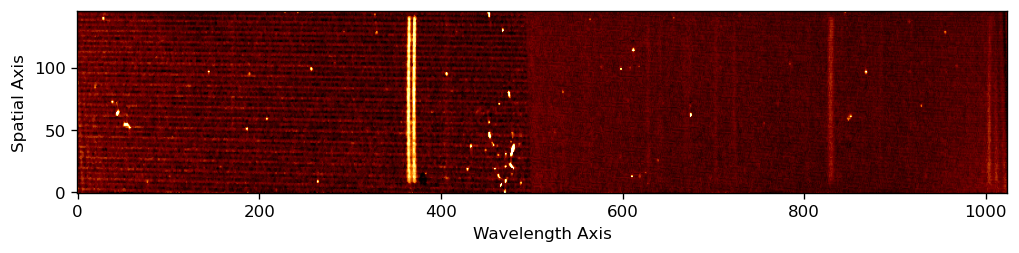

In [2]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p_map_stack.ipynb' + "/../../")
filepath = os.path.join(os.path.dirname(notebook_path), 'spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load waverange
waverange = fits.open(filepath + 'order37/waverange.fits', ignore_missing_end=True)[0].data

# load skylines
skylines60m = fits.open(filepath + 'order37/skylines60m_order37.fits', ignore_missing_end=True)[0].data
skylines60p = fits.open(filepath + 'order37/skylines60p_order37.fits', ignore_missing_end=True)[0].data
skylines_shifted = fits.open(filepath + 'order37/skylines_shifted_order37.fits', ignore_missing_end=True)[0].data
skylines_corrected = fits.open(filepath + 'order37/skylines_corrected_order37.fits', ignore_missing_end=True)[0].data

# spat_lower = 220
# spat_upper = 360

plt.figure(figsize=(10,2))
plt.imshow(skylines60m, aspect='auto', cmap='afmhot')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0],waverange[-1],0,138], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 1024
    # variables        = 2
    chi-square         = 4.8573e-12
    reduced chi-square = 4.7528e-15
    Akaike info crit   = -33769.5758
    Bayesian info crit = -33759.7128
[[Variables]]
    slope:      2.8590e-05 +/- 7.2881e-12 (0.00%) (init = 2.859e-05)
    intercept:  2.06230592 +/- 4.3056e-09 (0.00%) (init = 2.062306)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.866


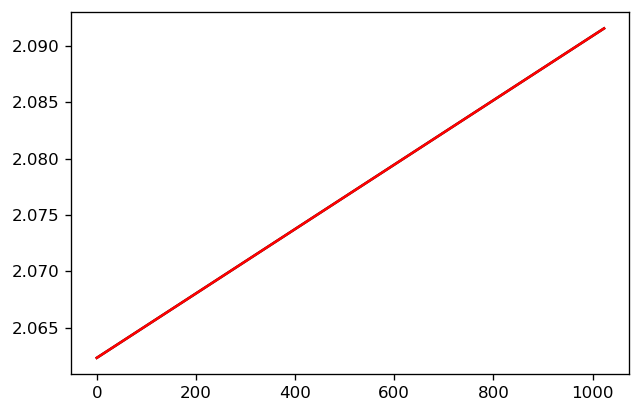

In [3]:
waveaxis = np.linspace(0, 1023, 1024)

mod = LinearModel()

pars = mod.guess(waverange, x=waveaxis)
out = mod.fit(waverange, pars, x=waveaxis)

print(out.fit_report(min_correl=0.25))

k = out.params['slope'].value
m = out.params['intercept'].value

wave_best_fit = k*waveaxis + m

plt.figure()
plt.plot(waveaxis, waverange,'k', label = 'original')
plt.plot(waveaxis, wave_best_fit, 'r', label = 'best fit')

Text(0, 0.5, 'CCD Counts')

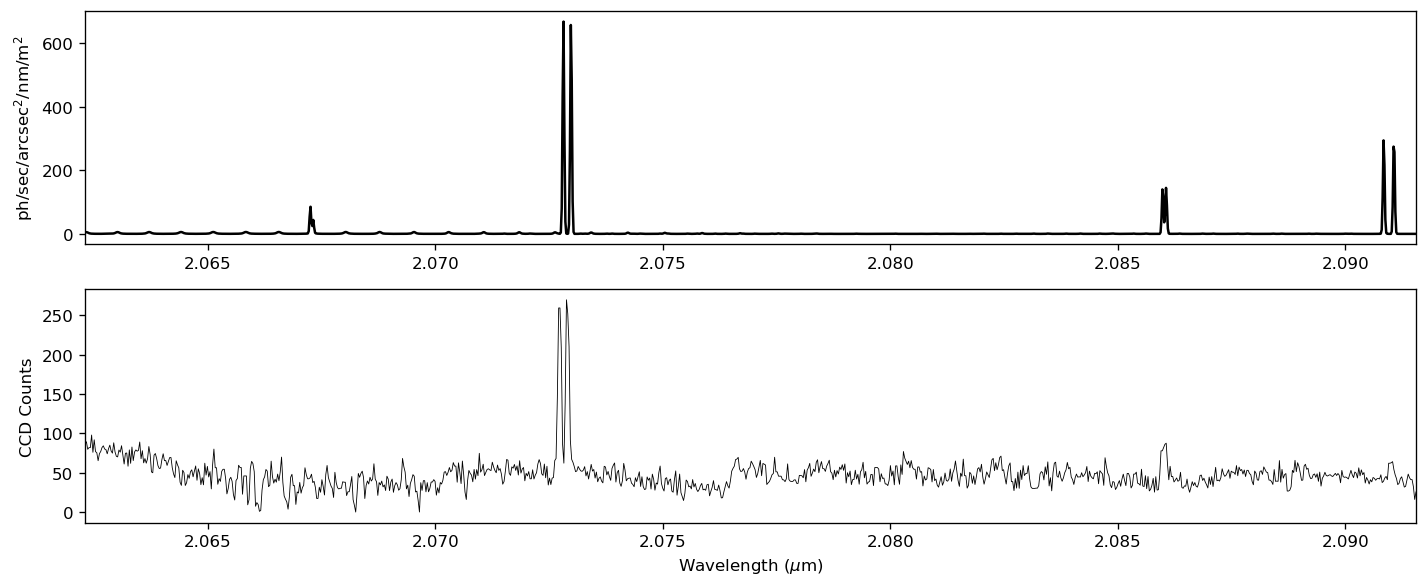

In [4]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[58100:59800,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[58100:59800,1]#[gemini_array[60500:62500,1]>0.5]

fig = plt.figure(figsize=(12,5), tight_layout=True)

fig.add_subplot(211)
plt.plot(wavelength, count, 'k', label='original')
plt.xlim(waverange[0], waverange[-1])
# plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
# plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
# plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')
# plt.legend()

fig.add_subplot(212)
plt.plot(waverange, skylines60m[105], 'k-', lw=0.5)
plt.xlim(waverange[0], waverange[-1])
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('CCD Counts')

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 134
    # data points      = 15
    # variables        = 6
    chi-square         = 14.2003946
    reduced chi-square = 1.57782163
    Akaike info crit   = 11.1782933
    Bayesian info crit = 15.4265945
[[Variables]]
    a0:  677.295986 +/- 1.32456390 (0.20%) (init = 660)
    a1:  207281.707 +/- 0.00382452 (0.00%) (init = 207283)
    a2:  1.85976860 +/- 0.00277206 (0.15%) (init = 10)
    a3:  12074.8277 +/- 4697356.61 (38902.06%) (init = 0)
    a4: -0.00635926 +/- 45.3258659 (712754.04%) (init = 0)
    a5: -2.5033e-07 +/- 1.0934e-04 (43678.02%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.392
    C(a0, a3) =  0.325
    C(a0, a4) = -0.325
    C(a0, a5) =  0.324
207281.7069733006


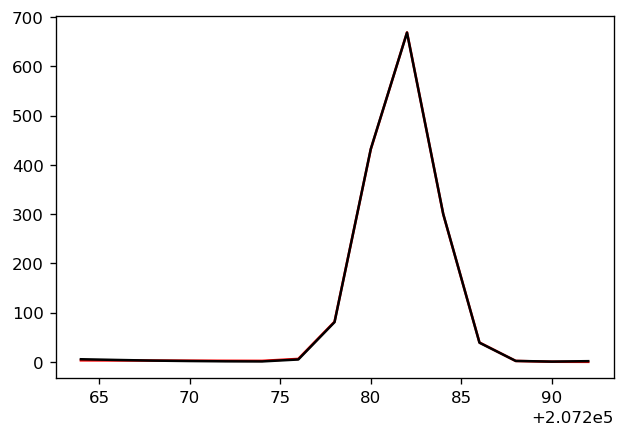

In [22]:
# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=660, min=650)
g1_params.add('a1', value=207283, min=207265)
g1_params.add('a2', value=10)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(count[532:547], g1_params, x=wavelength[532:547]*1e5)
except:
    pass

print(g1_result.fit_report(min_correl=0.25))

plt.plot(wavelength[532:547]*1e5, g1_result.best_fit, 'r-', label='best fit')
plt.plot(wavelength[532:547]*1e5, count[532:547], 'k', label='original')
#plt.xlim(2.123,2.1235)

print(g1_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 163
    # data points      = 14
    # variables        = 6
    chi-square         = 1.94051818
    reduced chi-square = 0.24256477
    Akaike info crit   = -15.6654321
    Bayesian info crit = -11.8310881
[[Variables]]
    a0:  683.865578 +/- 0.49615332 (0.07%) (init = 658)
    a1:  207298.500 +/- 0.00173362 (0.00%) (init = 207298)
    a2:  1.86111529 +/- 0.00117168 (0.06%) (init = 10)
    a3:  152.740188 +/- 1809651.32 (1184790.55%) (init = 0)
    a4:  0.01560983 +/- 17.4472923 (111771.16%) (init = 0)
    a5: -7.8843e-08 +/- 4.2053e-05 (53338.12%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a3, a4) = -1.000
    C(a4, a5) = -1.000
    C(a3, a5) =  1.000
    C(a1, a3) =  0.531
    C(a1, a4) = -0.531
    C(a1, a5) =  0.531
    C(a2, a3) = -0.348
    C(a2, a4) =  0.348
    C(a2, a5) = -0.348
    C(a0, a2) = -0.347
207298.49982465996


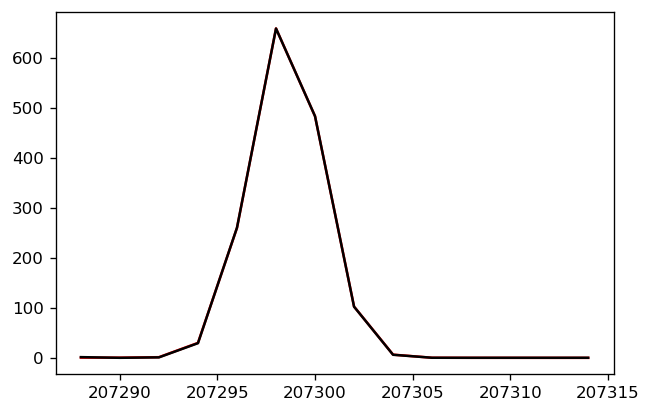

In [19]:
# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)

# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=658, min=640)
g2_params.add('a1', value=207298, max=207310)
g2_params.add('a2', value=10)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count[544:558], g2_params, x=wavelength[544:558]*1e5)
except:
    pass

print(g2_result.fit_report(min_correl=0.25))

plt.plot(wavelength[544:558]*1e5, g2_result.best_fit, 'r-', label='best fit')
plt.plot(wavelength[544:558]*1e5, count[544:558], 'k', label='original')

print(g2_result.params['a1'].value)

array([207286., 207288., 207290., 207292., 207294., 207296., 207298.,
       207300., 207302., 207304., 207306., 207308., 207310., 207312.,
       207314.])

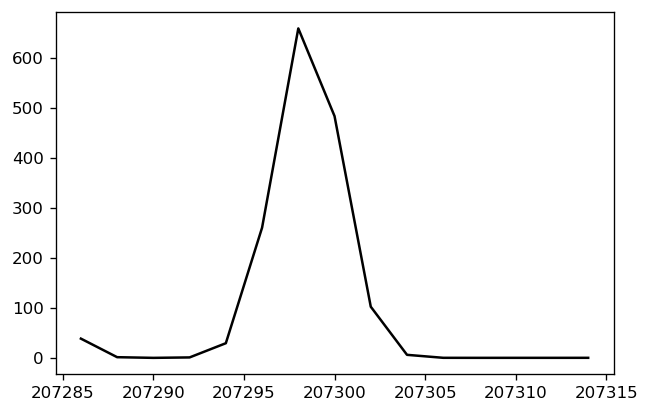

In [20]:
plt.plot(wavelength[543:558]*1e5, count[543:558], 'k', label='original')
wavelength[543:558]*1e5

[[Model]]
    (Model(gaussian_fit, prefix='g1_') + Model(gaussian_fit, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 30
    # variables        = 12
    chi-square         = 557077.365
    reduced chi-square = 30948.7425
    Akaike info crit   = 318.877861
    Bayesian info crit = 335.692229
##  Warning: uncertainties could not be estimated:
    g1_a1:  at initial value
    g1_a2:  at initial value
    g2_a1:  at initial value
    g2_a2:  at initial value
[[Variables]]
    g1_a0:  659.860446 +/- 4.0569e+09 (614812932.81%) (init = 660)
    g1_a1:  2.07282001 +/- 376.695411 (18173.09%) (init = 2.07282)
    g1_a2:  1.0000e-04 +/- 12431734.1 (12431734075708.93%) (init = 0.0001)
    g1_a3:  2.79501640 +/- 4.4447e+09 (159022573858.64%) (init = 1)
    g1_a4:  0.86595425 +/- 5.2778e+08 (60947617951.54%) (init = 0)
    g1_a5:  0.41775471 +/- 3.1134e+08 (74527632325.65%) (init = 0)
    g2_a0:  649.837376 +/-        nan (nan

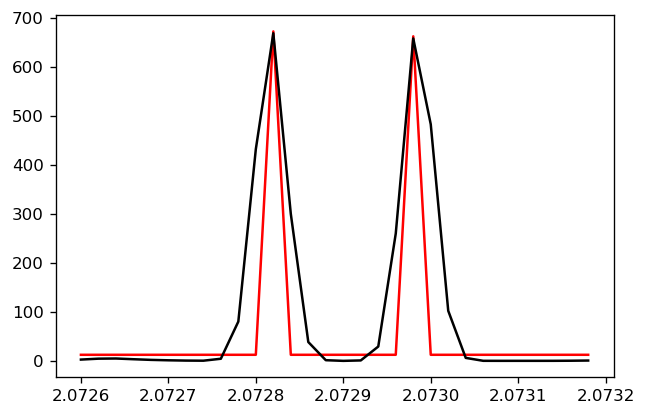

In [23]:
gmodel = Model(gaussian_fit, prefix='g1_') + Model(gaussian_fit, prefix='g2_')

gparams = gmodel.make_params()

# add parameters for 1st fit
gparams.add('g1_a0', value=660)
gparams.add('g1_a1', value=2.07282)
gparams.add('g1_a2', value=0.0001)
gparams.add('g1_a3', value=1)
gparams.add('g1_a4', value=0)
gparams.add('g1_a5', value=0)

# add parameters for 2nd fit
gparams.add('g2_a0', value=650)
gparams.add('g2_a1', value=2.07298)
gparams.add('g2_a2', value=0.0001)
gparams.add('g2_a3', value=1)
gparams.add('g2_a4', value=0)
gparams.add('g2_a5', value=0)

gmodel_fit = gmodel.fit(count[530:560], gparams, x=wavelength[530:560])

print(gmodel_fit.fit_report())

plt.plot(wavelength[530:560], gmodel_fit.best_fit, 'r-', label='best fit')
plt.plot(wavelength[530:560], count[530:560], 'k', label='original')

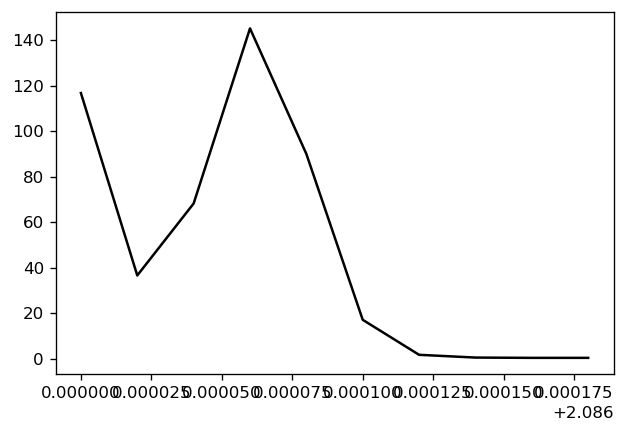

In [28]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[58100:59600,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[58100:59600,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength[1200:1210], count[1200:1210], 'k', label='original')
# plt.xlim(waverange[0], waverange[-1])

# np.where(count[1150:1250])

# create lmfit model with defined gaussian
# g1_model = Model(gaussian_fit)

# # create parameters and add initial guess
# g1_params = g1_model.make_params()
# g1_params.add('a0', value=150, min=130, max=200)
# g1_params.add('a1', value=2.0855, min=2.085, max=2.09)
# g1_params.add('a2', value=0.003, min=0)
# g1_params.add('a3', value=0)
# g1_params.add('a4', value=0)
# g1_params.add('a5', value=0)

# g_model = g1_model

# try:
#     g1_result = g_model.fit(count, g1_params, x=wavelength)
# except:
#     pass

# # print(g1_result.fit_report(min_correl=0.25))

# plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
# plt.xlim(2.085,2.090)

# print(g1_result.params['a1'].value)

In [60]:
wavelength[1201]

2.08602

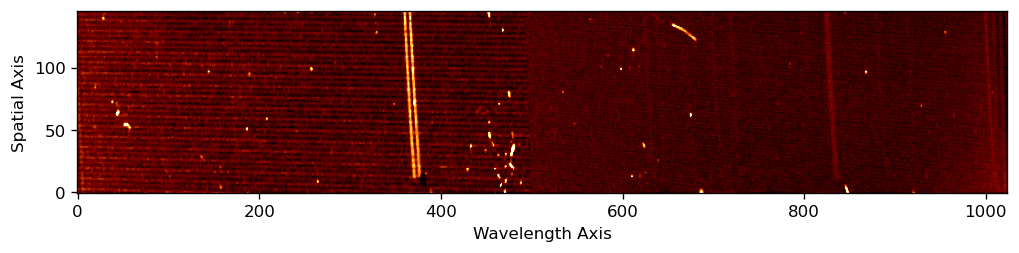

In [39]:
plt.figure(figsize=(10,2))
plt.imshow(skylines60p, aspect='auto', cmap='afmhot')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0],waverange[-1],0,138], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [7]:
(wavelength[1201]-m)/k

829.4537121370682

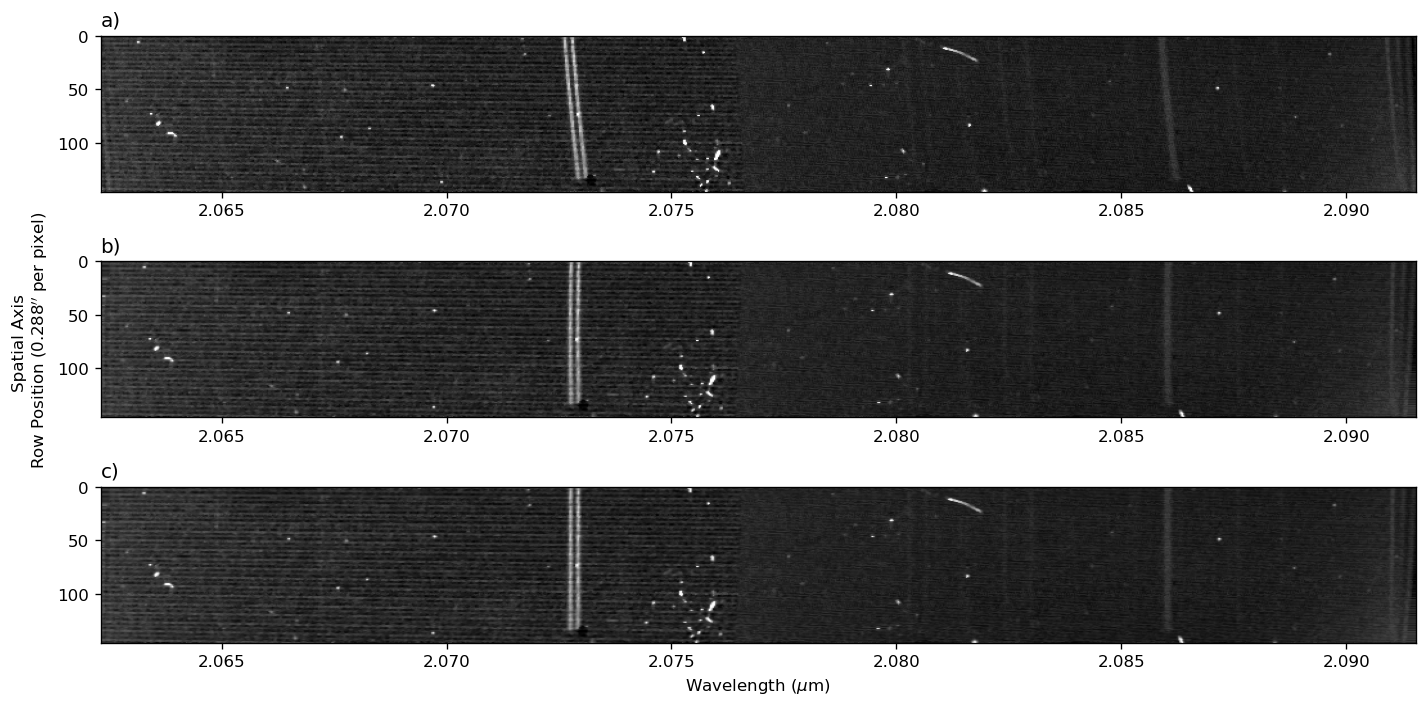

In [5]:
fig = plt.figure(figsize=(12,6), tight_layout=True)

fig.add_subplot(311)
plt.imshow(skylines60p, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
# plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
# plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
# plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
# plt.xlim(waverange[0], waverange[511])
# plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')
# plt.legend()
plt.title('a)', loc='left')
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(312)
plt.imshow(skylines_shifted, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
# plt.xlabel('Wavelength ($\mu$m)')
plt.title('b)', loc='left')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(313)
plt.imshow(skylines_corrected, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
plt.title('c)', loc='left')
plt.xlabel('Wavelength ($\mu$m)')
plt.gca().invert_yaxis()

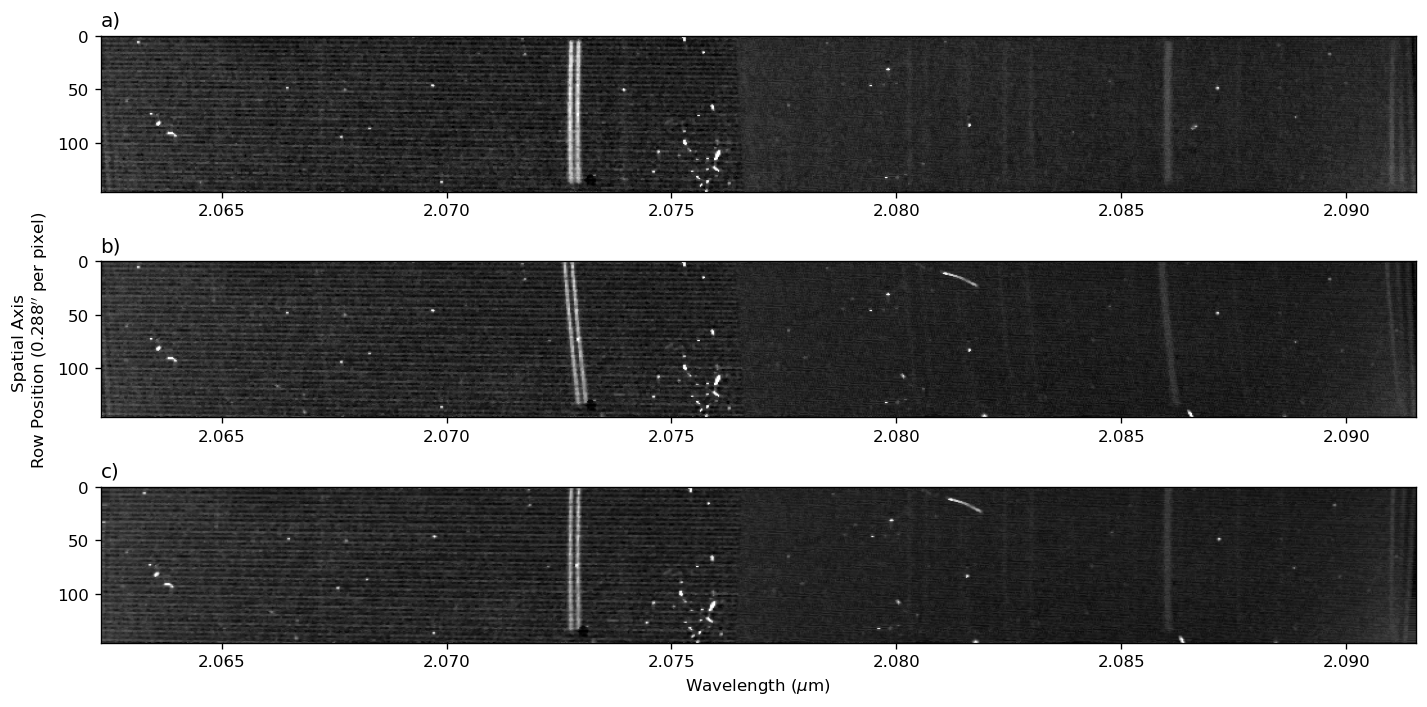

In [21]:
fig = plt.figure(figsize=(12,6), tight_layout=True)

fig.add_subplot(311)
plt.imshow(skylines60m, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
# plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
# plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
# plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
# plt.xlim(waverange[0], waverange[511])
# plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')
# plt.legend()
plt.title('a)', loc='left')
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(312)
plt.imshow(skylines60p, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
# plt.xlabel('Wavelength ($\mu$m)')
plt.title('b)', loc='left')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(313)
plt.imshow(skylines_shifted, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
plt.title('c)', loc='left')
plt.xlabel('Wavelength ($\mu$m)')
plt.gca().invert_yaxis()

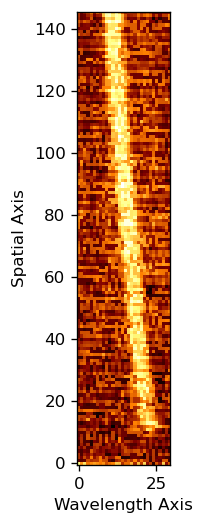

In [93]:
a = np.delete(skylines60p, np.s_[844:], 1)
b = np.delete(a, np.s_[:814], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

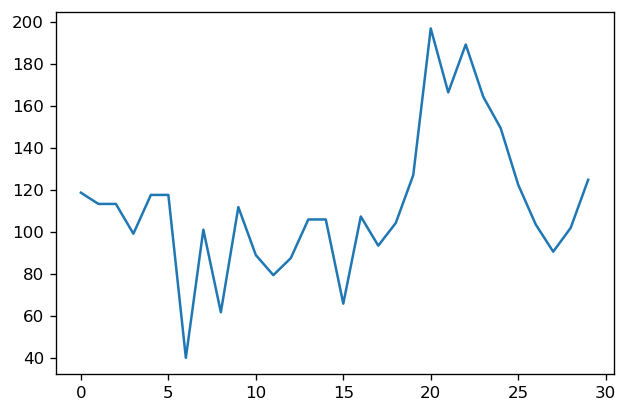

In [67]:
plt.plot(b[15])

In [99]:
b.shape

(146, 30)

Error occured at i=85
Error occured at i=89
Error occured at i=139


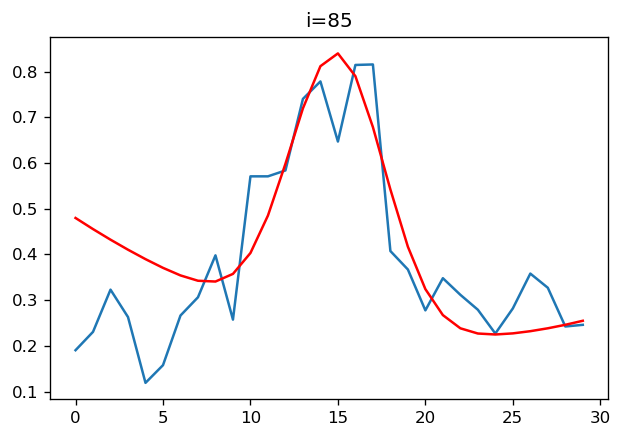

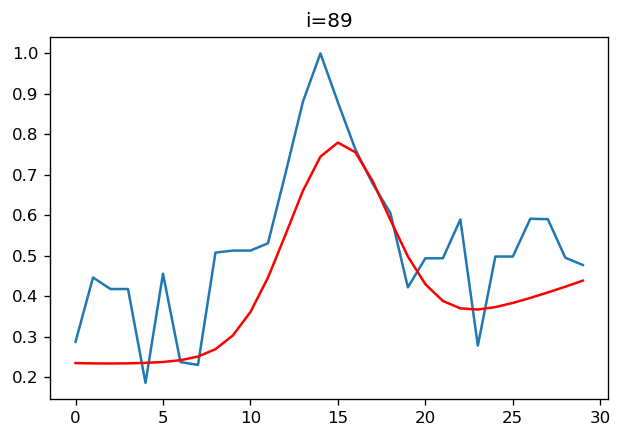

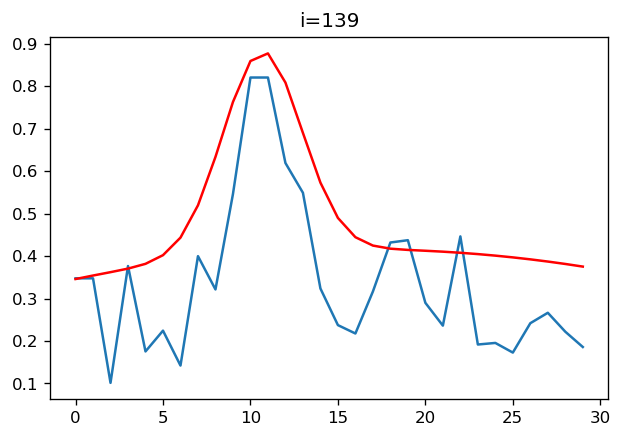

In [96]:
a = np.delete(skylines60p, np.s_[844:], 1)
b = np.delete(a, np.s_[:814], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 145
lower_skyline = 15

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.8, min=0.4, max=1)
        sky1_params.add('a1', value=20, min=10, max=27)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+814#/100000

In [97]:
sky1_a1

array([835.4045917 , 835.53871344, 834.97948484, 835.47304788,
       834.09009059, 836.16709772, 835.18039349, 834.66302454,
       834.79460029, 834.71344593, 834.15863404, 834.4168107 ,
       834.50812026, 833.4231894 , 834.08200835, 833.8338569 ,
       834.21314468, 833.84393   , 833.55696846, 833.61360482,
       833.20771497, 833.18158728, 832.82434007, 833.63334499,
       832.44938795, 832.68160683, 832.85039774, 832.33981858,
       832.36336501, 833.11848008, 832.74965681, 832.11880497,
       832.43734914, 831.45878227, 831.8072977 , 832.00705686,
       832.48664577, 831.87765605, 831.93616707, 831.84090057,
       831.39940731, 831.93204957, 831.51053007, 831.27528118,
       831.67571472, 831.28918634, 831.67693159, 830.94442403,
       832.18032754, 831.10480165, 830.37953209, 830.37336253,
       830.09512556, 829.80123401, 830.54443012, 830.78336768,
       830.15952573, 831.02173586, 830.11791941, 830.26425835,
       830.06527029, 829.75264988, 829.84261548, 829.51

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 130
    # variables        = 2
    chi-square         = 27.2815258
    reduced chi-square = 0.21313692
    Akaike info crit   = -198.972209
    Bayesian info crit = -193.237140
[[Variables]]
    slope:     -0.08255552 +/- 0.00107899 (1.31%) (init = -0.08255552)
    intercept:  836.293489 +/- 0.09485613 (0.01%) (init = 836.2935)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.904


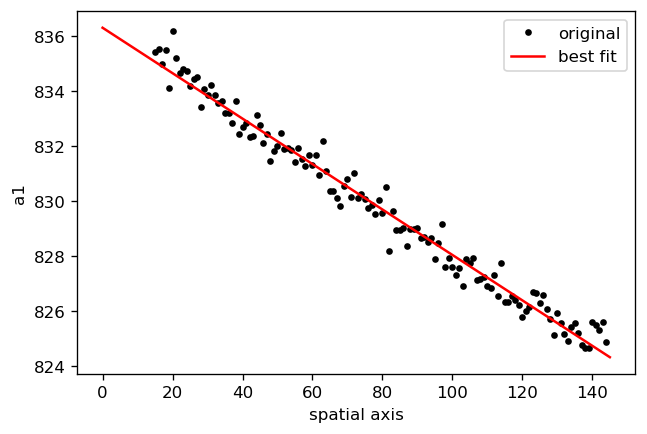

In [98]:
sky1_spat = np.linspace(0, len(sky1_a1)-1, len(sky1_a1))+15

x = sky1_spat
y = sky1_a1

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

slope = out.params['slope'].value
intercept = out.params['intercept'].value

sky1_spat_all = np.linspace(0, np.size(skylines60p,0)-1, np.size(skylines60p,0))
sky1_a1_best_fit = slope*sky1_spat_all + intercept

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k.', label = 'original')
plt.plot(sky1_spat_all, sky1_a1_best_fit, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [101]:
sky1_pixel_offset_order37 = (wavelength[1201]-m)/k - sky1_a1_best_fit
# np.savetxt('sky1_pixel_offset_order37.txt', sky1_pixel_offset_order37)
sky1_pixel_offset_order37

array([-6.83977681, -6.75722129, -6.67466576, -6.59211024, -6.50955472,
       -6.4269992 , -6.34444368, -6.26188816, -6.17933264, -6.09677712,
       -6.01422159, -5.93166607, -5.84911055, -5.76655503, -5.68399951,
       -5.60144399, -5.51888847, -5.43633294, -5.35377742, -5.2712219 ,
       -5.18866638, -5.10611086, -5.02355534, -4.94099982, -4.8584443 ,
       -4.77588877, -4.69333325, -4.61077773, -4.52822221, -4.44566669,
       -4.36311117, -4.28055565, -4.19800012, -4.1154446 , -4.03288908,
       -3.95033356, -3.86777804, -3.78522252, -3.702667  , -3.62011147,
       -3.53755595, -3.45500043, -3.37244491, -3.28988939, -3.20733387,
       -3.12477835, -3.04222283, -2.9596673 , -2.87711178, -2.79455626,
       -2.71200074, -2.62944522, -2.5468897 , -2.46433418, -2.38177865,
       -2.29922313, -2.21666761, -2.13411209, -2.05155657, -1.96900105,
       -1.88644553, -1.80389001, -1.72133448, -1.63877896, -1.55622344,
       -1.47366792, -1.3911124 , -1.30855688, -1.22600136, -1.14

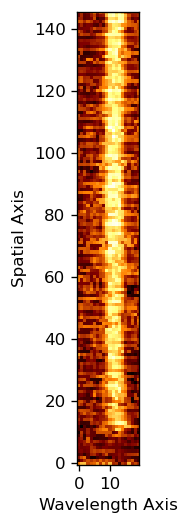

In [114]:
c = np.delete(skylines_shifted, np.s_[838:], 1)
d = np.delete(c, np.s_[:818], 1)

plt.figure(figsize=(2,5))
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [124]:
c = np.delete(skylines_shifted, np.s_[838:], 1)
d = np.delete(c, np.s_[:818], 1)
d = normalize(d)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[818:838]*100000

upper_skyline = 145
lower_skyline = 15

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):          
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.6)
        sky2_params.add('a1', value=208602, max=208700)
        sky2_params.add('a2', value=2)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(d[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1/100000

In [125]:
sky2_a1

array([2.08603317, 2.08603699, 2.08602546, 2.0860411 , 2.08599859,
       2.08606223, 2.08604105, 2.08602858, 2.08602978, 2.08603242,
       2.08601845, 2.08603019, 2.08603867, 2.08601273, 2.08602621,
       2.08602331, 2.08603351, 2.08602754, 2.08602039, 2.08602455,
       2.08601785, 2.08602798, 2.08601115, 2.08602301, 2.08600181,
       2.08600939, 2.08601554, 2.08600527, 2.0860106 , 2.08603626,
       2.08601501, 2.08601116, 2.08601682, 2.08599522, 2.08600837,
       2.08601311, 2.08602488, 2.08601488, 2.08601896, 2.08602699,
       2.08601414, 2.08602998, 2.0860227 , 2.08601528, 2.0860276 ,
       2.08602026, 2.08600943, 2.08601697, 2.0861045 , 2.08602293,
       2.08599972, 2.08600335, 2.08600063, 2.08599614, 2.0860242 ,
       2.08602761, 2.08601218, 2.08603062, 2.08602343, 2.0860174 ,
       2.08602017, 2.08601194, 2.08601616, 2.08601045, 2.08603164,
       2.08601678, 2.08604643, 2.08600459, 2.08602316, 2.08600812,
       2.0859886 , 2.08600873, 2.08599806, 2.08601853, 2.08599

[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 130
    # variables        = 3
    chi-square         = 2.4795e-08
    reduced chi-square = 1.9524e-10
    Akaike info crit   = -2903.42062
    Bayesian info crit = -2894.81802
[[Variables]]
    a:  4.3985e-09 +/- 9.7287e-10 (22.12%) (init = 4.398481e-09)
    b: -7.1393e-07 +/- 1.5809e-07 (22.14%) (init = -7.139268e-07)
    c:  2.08604292 +/- 5.5746e-06 (0.00%) (init = 2.086043)
[[Correlations]] (unreported correlations are < 0.250)
    C(a, b) = -0.978
    C(b, c) = -0.935
    C(a, c) =  0.857


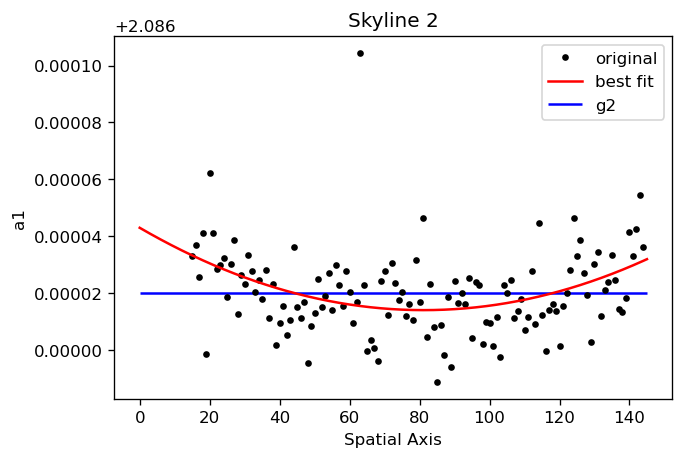

In [137]:
sky2_spat = np.linspace(0, len(sky1_a1)-1, len(sky1_a1))+15

x = sky2_spat
y = sky2_a1

mod = QuadraticModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(0, np.size(skylines60p,0)-1, np.size(skylines60p,0))
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
# sky2_c = out.params['c'].value
# sky2_a1_best_fit = sky2_c
sky2_a = out.params['a'].value
sky2_b = out.params['b'].value
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_a*sky2_spat_all**2+sky2_b*sky2_spat_all+sky2_c

plt.figure()
plt.plot(sky2_spat, sky2_a1,'.k', label = 'original')
plt.plot(sky2_spat_all, sky2_a1_best_fit,'r', label = 'best fit')
# plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(wavelength[1201], xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
# plt.ticklabel_format(useOffset=False)
plt.legend()

In [142]:
sky2_pixel_offset_order37 = (wavelength[1201] - sky2_a1_best_fit)/k
# np.savetxt('sky2_pixel_offset_order37.txt', sky2_pixel_offset_order37)
sky2_pixel_offset_order37 

array([-8.01620980e-01, -7.76803622e-01, -7.52293958e-01, -7.28091987e-01,
       -7.04197710e-01, -6.80611127e-01, -6.57332237e-01, -6.34361041e-01,
       -6.11697539e-01, -5.89341730e-01, -5.67293615e-01, -5.45553194e-01,
       -5.24120466e-01, -5.02995433e-01, -4.82178092e-01, -4.61668446e-01,
       -4.41466493e-01, -4.21572234e-01, -4.01985668e-01, -3.82706796e-01,
       -3.63735618e-01, -3.45072133e-01, -3.26716343e-01, -3.08668245e-01,
       -2.90927842e-01, -2.73495132e-01, -2.56370116e-01, -2.39552793e-01,
       -2.23043165e-01, -2.06841229e-01, -1.90946988e-01, -1.75360440e-01,
       -1.60081586e-01, -1.45110426e-01, -1.30446959e-01, -1.16091186e-01,
       -1.02043106e-01, -8.83027206e-02, -7.48700285e-02, -6.17450301e-02,
       -4.89277253e-02, -3.64181143e-02, -2.42161969e-02, -1.23219732e-02,
       -7.35443100e-04,  1.05433933e-02,  2.15145360e-02,  3.21779850e-02,
        4.25337404e-02,  5.25818020e-02,  6.23221700e-02,  7.17548444e-02,
        8.08798250e-02,  

In [146]:
slit_pixel_offset_order37 = sky1_pixel_offset_order37 + sky2_pixel_offset_order37
# np.savetxt('slit_pixel_offset_order37.txt', slit_pixel_offset_order37)
slit_pixel_offset_order37

array([-7.64139779, -7.53402491, -7.42695972, -7.32020223, -7.21375243,
       -7.10761033, -7.00177592, -6.8962492 , -6.79103018, -6.68611885,
       -6.58151521, -6.47721927, -6.37323102, -6.26955046, -6.1661776 ,
       -6.06311243, -5.96035496, -5.85790518, -5.75576309, -5.6539287 ,
       -5.552402  , -5.45118299, -5.35027168, -5.24966806, -5.14937214,
       -5.04938391, -4.94970337, -4.85033052, -4.75126537, -4.65250792,
       -4.55405815, -4.45591609, -4.35808171, -4.26055503, -4.16333604,
       -4.06642475, -3.96982115, -3.87352524, -3.77753702, -3.6818565 ,
       -3.58648368, -3.49141855, -3.39666111, -3.30221136, -3.20806931,
       -3.11423495, -3.02070829, -2.92748932, -2.83457804, -2.74197446,
       -2.64967857, -2.55769037, -2.46600987, -2.37463706, -2.28357195,
       -2.19281453, -2.1023648 , -2.01222277, -1.92238843, -1.83286178,
       -1.74364283, -1.65473157, -1.566128  , -1.47783213, -1.38984395,
       -1.30216347, -1.21479068, -1.12772558, -1.04096818, -0.95

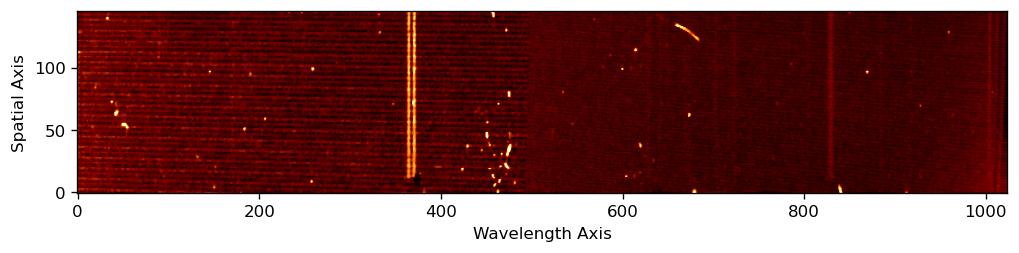

In [8]:
plt.figure(figsize=(10,2))
plt.imshow(skylines_corrected, aspect='auto', cmap='afmhot')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0],waverange[-1],0,138], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

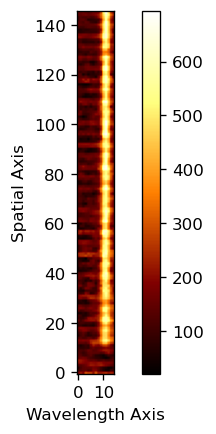

In [16]:
a = np.delete(skylines_corrected, np.s_[369:], 1)
b = np.delete(a, np.s_[:354], 1)

plt.figure()
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

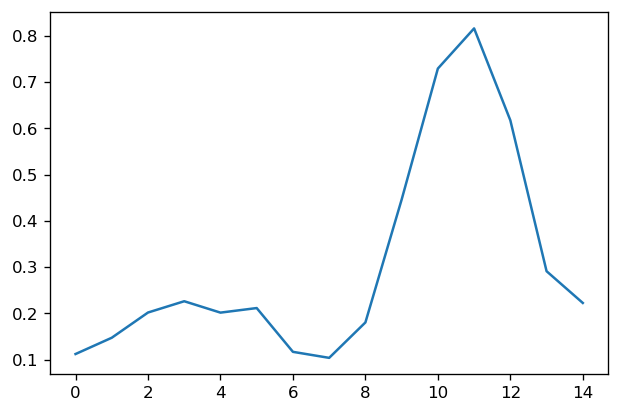

In [23]:
plt.plot(b[50])

In [19]:
a = np.delete(skylines_corrected, np.s_[369:], 1)
b = np.delete(a, np.s_[:354], 1)
b = normalize(b)
waveaxis = waverange[354:369]*100000

upper_skyline = 145
lower_skyline = 15

sky1_wave = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=207275)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.2)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_wave[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_wave = sky1_wave/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 130
    # variables        = 1
    chi-square         = 1.7561e-09
    reduced chi-square = 1.3613e-11
    Akaike info crit   = -3251.60136
    Bayesian info crit = -3248.73382
[[Variables]]
    c:  2.07273635 +/- 3.2360e-07 (0.00%) (init = 2.072736)


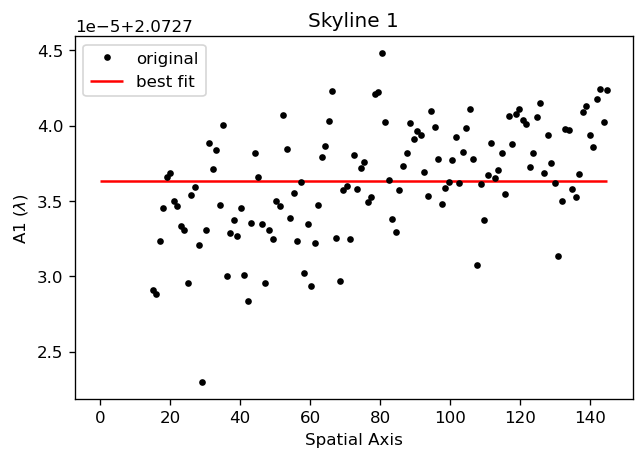

In [36]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_wave))

x = sky1_spat
y = sky1_wave

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, np.size(b,0)-1, np.size(b,0))
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_wave_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_wave_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 ($\lambda$)')
plt.legend()

Error occured at i=15
Error occured at i=27
Error occured at i=37
Error occured at i=50
Error occured at i=54
Error occured at i=65
Error occured at i=100
Error occured at i=124


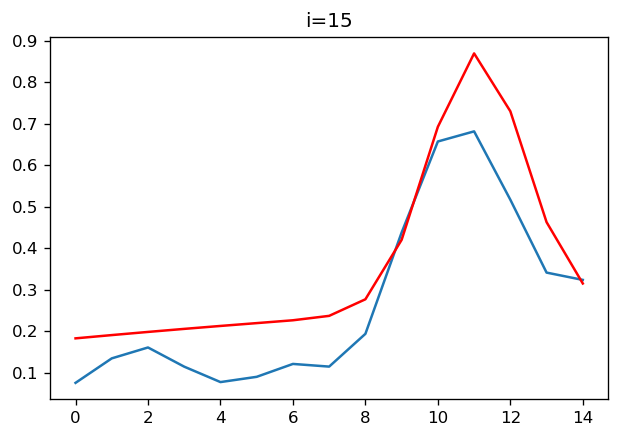

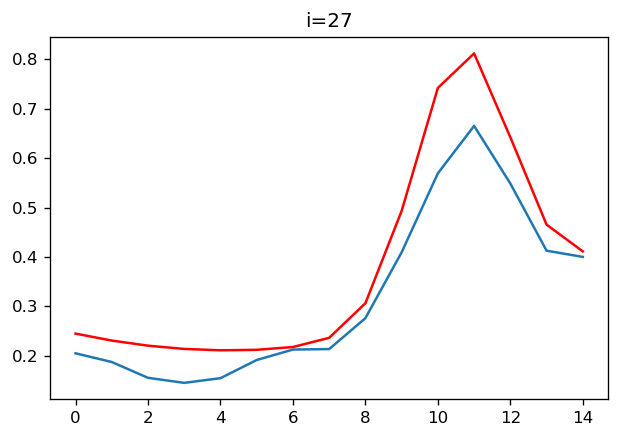

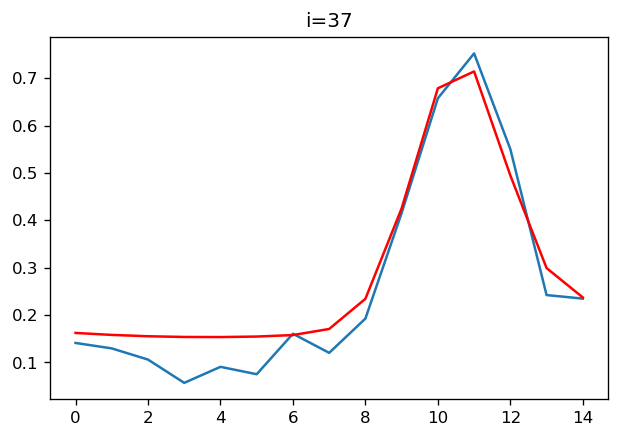

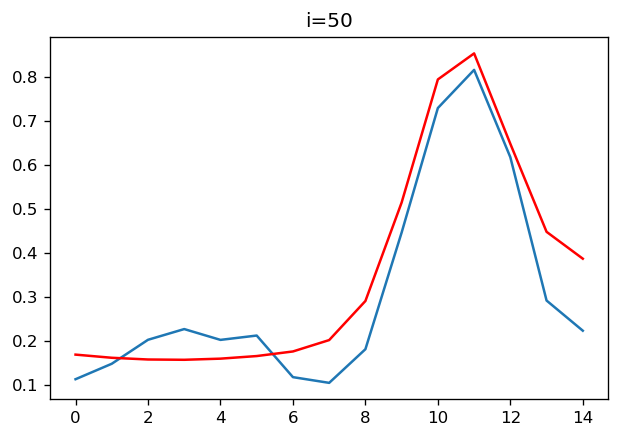

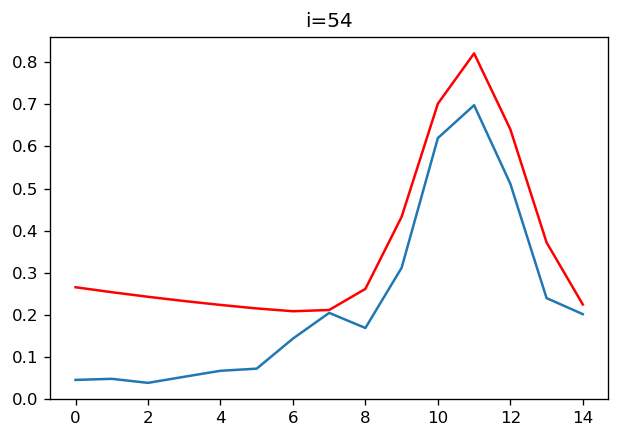

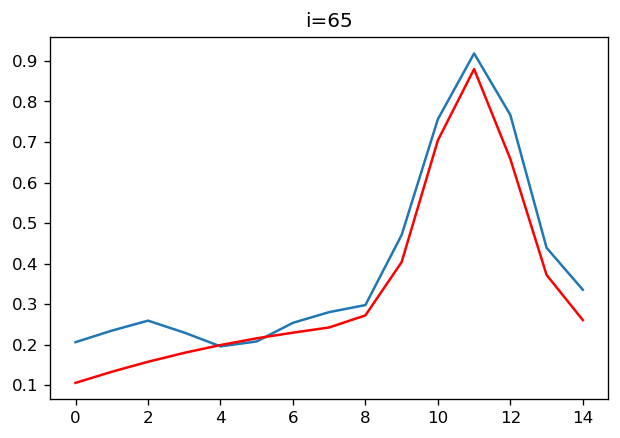

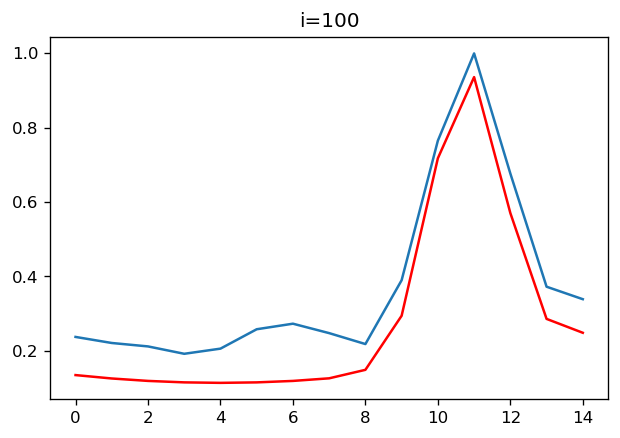

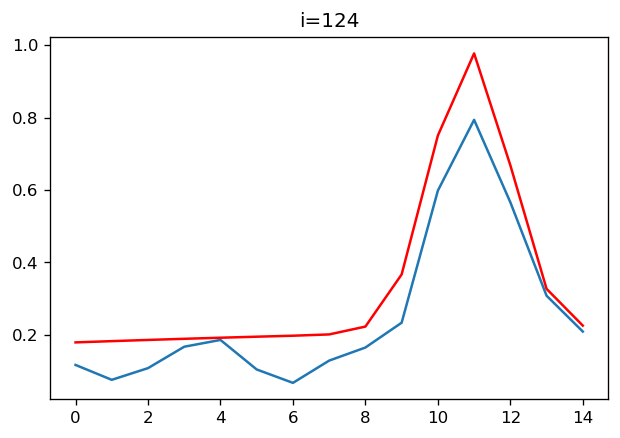

In [32]:
a = np.delete(skylines_corrected, np.s_[369:], 1)
b = np.delete(a, np.s_[:354], 1)
b = normalize(b)
waveaxis = np.linspace(0 ,np.size(b,1)-1, np.size(b,1))

upper_skyline = 145
lower_skyline = 15

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.8)
        sky1_params.add('a1', value=11, min=8, max=12)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.2)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+354

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 130
    # variables        = 1
    chi-square         = 5.66758069
    reduced chi-square = 0.04393473
    Akaike info crit   = -405.260374
    Bayesian info crit = -402.392840
[[Variables]]
    c:  364.798655 +/- 0.01838367 (0.01%) (init = 364.7987)


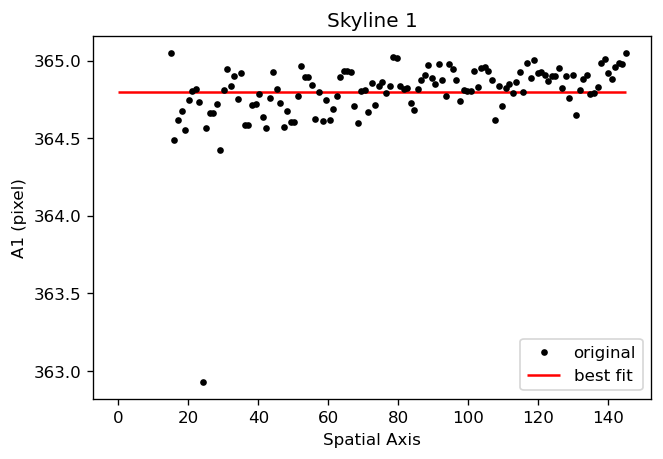

In [35]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_wave))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, np.size(b,0)-1, np.size(b,0))
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

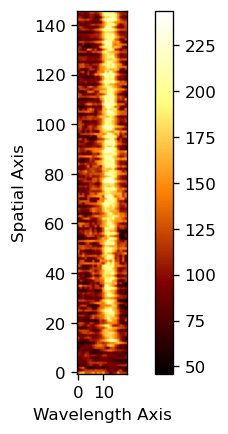

In [43]:
c = np.delete(skylines_corrected, np.s_[837:], 1)
d = np.delete(c, np.s_[:817], 1)

plt.figure()
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

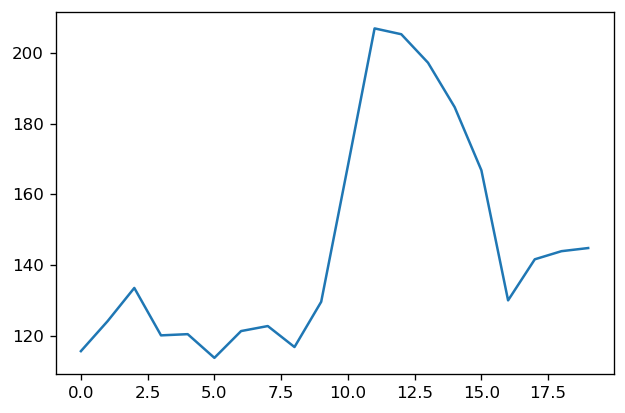

In [45]:
plt.plot(d[50])

In [52]:
c = np.delete(skylines_corrected, np.s_[837:], 1)
d = np.delete(c, np.s_[:817], 1)
d = normalize(d)
waveaxis = waverange[817:837]*100000

upper_skyline = 145
lower_skyline = 15

sky3_wave = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):            
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.7)
        sky3_params.add('a1', value=208602, max=208608)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(d[i]), sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, normalize(d[i]))
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_wave[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_wave = sky3_wave/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 130
    # variables        = 1
    chi-square         = 2.0409e-08
    reduced chi-square = 1.5821e-10
    Akaike info crit   = -2932.72982
    Bayesian info crit = -2929.86229
[[Variables]]
    c:  2.08602100 +/- 1.1032e-06 (0.00%) (init = 2.086021)


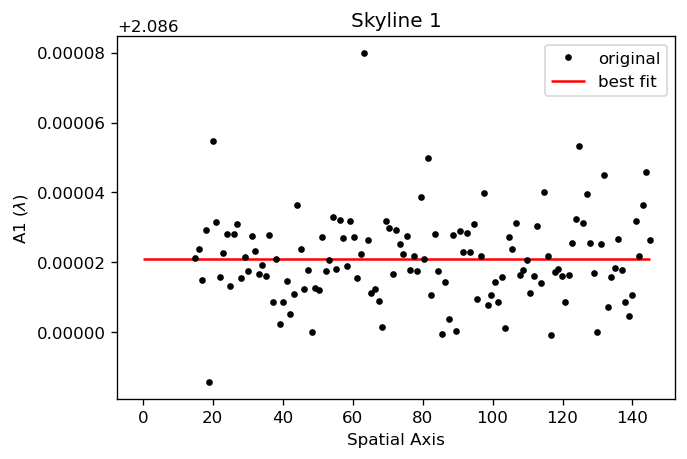

In [53]:
sky3_spat = np.linspace(lower_skyline, upper_skyline, len(sky3_wave))

x = sky3_spat
y = sky3_wave

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(0, np.size(d,0)-1, np.size(d,0))
# sky3_slope = out.params['slope'].value
# sky3_intercept = out.params['intercept'].value
sky3_c = out.params['c'].value
sky3_wave_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_wave_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 ($\lambda$)')
plt.legend()

Error occured at i=128


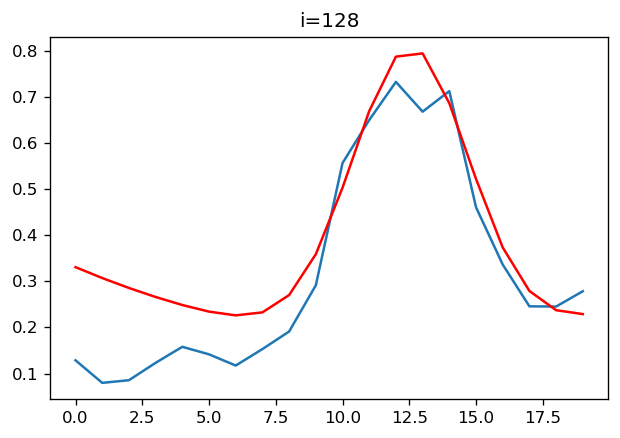

In [55]:
c = np.delete(skylines_corrected, np.s_[837:], 1)
d = np.delete(c, np.s_[:817], 1)
d = normalize(d)
waveaxis = np.linspace(0 ,np.size(d,1)-1, np.size(d,1))

upper_skyline = 145
lower_skyline = 15

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.8)
        sky3_params.add('a1', value=12.5, min=8, max=16)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(d[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
sky3_a1 = sky3_a1+817

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 130
    # variables        = 1
    chi-square         = 33.4029043
    reduced chi-square = 0.25893724
    Akaike info crit   = -174.655908
    Bayesian info crit = -171.788373
[[Variables]]
    c:  829.491760 +/- 0.04462987 (0.01%) (init = 829.4918)


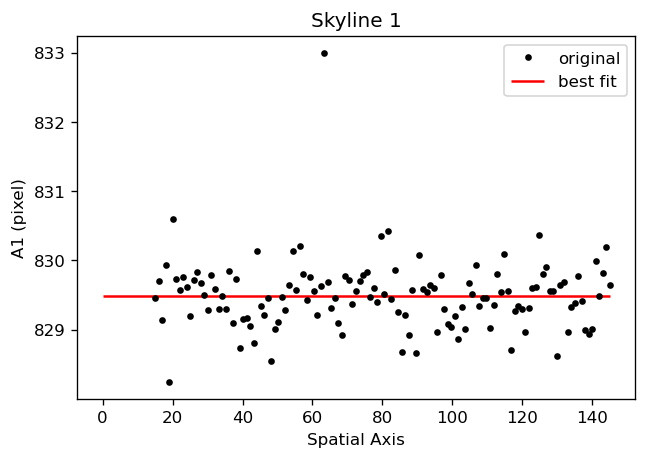

In [56]:
sky3_spat = np.linspace(lower_skyline, upper_skyline, len(sky3_wave))

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(0, np.size(d,0)-1, np.size(d,0))
# sky3_slope = out.params['slope'].value
# sky3_intercept = out.params['intercept'].value
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

In [58]:
print(sky1_wave_best_fit)
print(sky3_wave_best_fit)
print(sky1_a1_best_fit)
print(sky3_a1_best_fit)

R = (sky1_wave_best_fit + sky3_wave_best_fit)*0.5/((sky3_wave_best_fit - sky1_wave_best_fit)/(sky3_a1_best_fit - sky1_a1_best_fit))
R

2.072736349219198
2.0860209995839525
364.79865537439696
829.4917603269752


72736.04543958924